## Import & Merge Data

In [1]:
import datetime
import os
import sys
import re

import io
import numpy as np
import pandas as pd
import pymysql.cursors
from sqlalchemy import create_engine

In [25]:
import psycopg2 as pg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [10]:
Athena=pd.read_csv('/Users/wangecho/Documents/User_Migration/V3/Athena_data2.csv')
video_pd=pd.read_csv('/Users/wangecho/Documents/User_Migration/V3/Video_IDs.csv')

In [4]:
Athena.head()

,channel_id,video_id,channel_name,video_name,category,view_count,comment_count,length,shares,likes,dislikes,avg_view_percent,end_screen_element_id,end_screen_element_type,impressions,clicks,ctr
0,UCboMX_UNgaPBsUOIgasn3-Q,bMgv9pK1R70,Funhaus,ERECTILE DESTRUCTION - Demo Disk Gameplay,Gadgets & Games,635535,739,805,102,1316,16,36.539130,1cb300ad-e948-4ed8-873a-83cee92b77cc,playlist,63242,2844,0.044970
1,UCB9_VH_CNbbH4GfKu8qh63w,YgFxjaQIQ1c,ScrewAttack,Pokemon Minus Misty's Voltorbs | The Desk of D...,Entertainment,99540,410,319,201,3934,147,15.298748,63b98e01-0d1d-48d4-bcab-efec9d1c3089,video,53428,804,0.015048
2,UCB9_VH_CNbbH4GfKu8qh63w,YgFxjaQIQ1c,ScrewAttack,11162018DeskofPokemonMinusMistysVoltorbsYT,Entertainment,0,0,319,201,3934,147,15.298748,63b98e01-0d1d-48d4-bcab-efec9d1c3089,video,53428,804,0.015048
3,UCB9_VH_CNbbH4GfKu8qh63w,bBmUNjTRvAE,ScrewAttack,Top 10 Nightmare Fuel in Kids Movies,Entertainment,90014,728,713,231,3488,97,14.412903,752a25a4-eb34-433f-8ce3-b6bf61340303,associated,39921,18,0.000451
4,UCzH3iADRIq1IJlIXjfNgTpA,FeQ-QlTGiPQ,Rooster Teeth,Rooster Teeth Animated Adventures - Crazy Taxi,Film & Animation,951214,319,131,390,5645,47,42.481294,3e0c8dc8-3ce5-f7a0-346b-83325f0a7a50,video,104598,435,0.004159


In [11]:
video_pd = video_pd.rename({'Video_ID': 'video_id'}, axis=1)
video_pd.head()

,video_id
0,FGlPKEMs_zs
1,W1Yx4lyavus
2,wG40XZay_7g
3,i6IrPzOcAaI
4,XfD8koJae10


In [12]:
#Only going to focus on the videos in the list
Athena2=pd.merge(video_pd, Athena, how='inner',on='video_id')

## Initial data cleaning

In [95]:
Athena2['length'].describe()
Athena2['view_count'].min()
Athena2['comment_count'].min()

0

In [96]:
#remove videos <25 sec due to only videos > 25 sec can have endscreens
data1=Athena2.loc[Athena2['length']>=25]
#data1=data1.loc[data1['view_count']>=0]
#data1=data1.loc[data1['comment_count']>=0]

In [99]:
data1['likes'].describe()
data1['dislikes'].describe()

count    53393.000000
mean        27.405802
std        192.293589
min       -146.000000
25%          1.000000
50%          4.000000
75%         14.000000
max       8004.000000
Name: dislikes, dtype: float64

In [100]:
# remove bad data points
#data1=data1.loc[data1['shares']>=0]
data1=data1.loc[data1['likes']>=0]
data1=data1.loc[data1['dislikes']>=0]

In [101]:
# Check if NA exists
data1.isnull().any()

video_id                   False
channel_id                 False
channel_name               False
video_name                 False
category                   False
view_count                 False
comment_count              False
length                     False
shares                     False
likes                      False
dislikes                   False
avg_view_percent            True
end_screen_element_id      False
end_screen_element_type    False
impressions                False
clicks                     False
ctr                        False
dtype: bool

In [102]:
len(data1['avg_view_percent'].loc[data1['avg_view_percent'].isnull()])


97

In [103]:
# remove NA from data
data1=data1.loc[~data1['avg_view_percent'].isnull()]

In [104]:
data1['avg_view_percent'].describe()

count    48508.000000
mean        10.496912
std         13.236911
min          0.000000
25%          0.980998
50%          4.545455
75%         15.620000
max        240.000000
Name: avg_view_percent, dtype: float64

In [106]:
# remove bad data with avg_view_percent >100%
data1['avg_view_percent'].loc[data1['avg_view_percent']>100]
data1=data1.loc[data1['avg_view_percent']<=100]

In [142]:
len(data.loc[(data['avg_view_percent']==0)&(data['impressions']!=0)])/len(data['avg_view_percent'])
# 10% data has avg_view_percent=0 but impressions not 0. Seems to be bad data. 

0.10364168763145956

##### Needs to be more mindful in pulling data for the actual model !!!

In [143]:
# remove bad data with avg_view_percent =0
data1=data1.loc[data1['avg_view_percent']!=0]

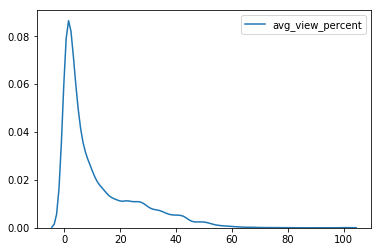

In [145]:
sns.kdeplot(data1['avg_view_percent'])


In [146]:
data1['avg_view_percent'].describe()

count    43468.000000
mean        11.701255
std         13.375207
min          0.001488
25%          1.854139
50%          5.883270
75%         17.974928
max        100.000000
Name: avg_view_percent, dtype: float64

In [108]:
data1.columns

Index(['video_id', 'channel_id', 'channel_name', 'video_name', 'category',
       'view_count', 'comment_count', 'length', 'shares', 'likes', 'dislikes',
       'avg_view_percent', 'end_screen_element_id', 'end_screen_element_type',
       'impressions', 'clicks', 'ctr'],
      dtype='object')

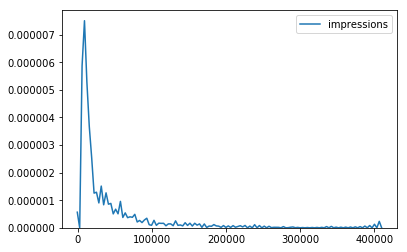

In [148]:
sns.kdeplot(data1['impressions'])


In [149]:
data1['impressions'].describe()

count     43468.000000
mean       6095.478007
std       23000.306147
min           1.000000
25%          15.000000
50%         141.000000
75%        1754.250000
max      409430.000000
Name: impressions, dtype: float64

In [150]:
data1['ctr'].describe()

count    43468.000000
mean         0.007585
std          0.022978
min          0.000000
25%          0.000000
50%          0.000000
75%          0.006152
max          0.500000
Name: ctr, dtype: float64

In [151]:
len(data1['ctr'].loc[data1['ctr']==0.000000])

22341

In [152]:
# remove data points with ctr=1
data1=data1.loc[data1['ctr']!=1]

In [153]:
data1.ctr.describe()

count    43468.000000
mean         0.007585
std          0.022978
min          0.000000
25%          0.000000
50%          0.000000
75%          0.006152
max          0.500000
Name: ctr, dtype: float64

In [154]:
len(data1['ctr'].loc[data1['ctr']>=0.01])/len(data1['ctr']) #about 18% videos have CTR >=0.01

0.1837903745283887

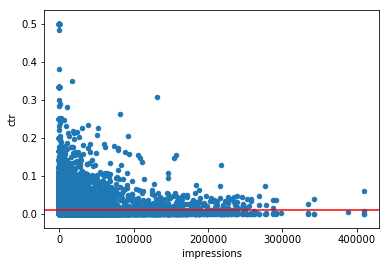

In [155]:
data1.plot.scatter(x='impressions',y='ctr')
plt.axhline(y=0.01, color='r', linestyle='-')

#### Notes:
##### Turn it into a classifier problem by classifying ctr>=0.01 and ctr<0.01
##### Because the goal is to reach overall ctr 1%
##### Not going to remove points with low Impressions for now. 

In [156]:
# create the new binary target variable
data1['CTR'] = np.where(data1['ctr']>=0.01, 1, 0)

In [157]:
data1.head()

,video_id,channel_id,channel_name,video_name,category,view_count,comment_count,length,shares,likes,dislikes,avg_view_percent,end_screen_element_id,end_screen_element_type,impressions,clicks,ctr,CTR
5,W1Yx4lyavus,UCB9_VH_CNbbH4GfKu8qh63w,ScrewAttack,Daredevil (Marvel) VS Kenshi (Mortal Kombat) |...,Entertainment,401577,2009,126,912,11153,973,8.867963,2e557ce8-6b01-548d-d3af-c6beae238f2b,playlist,1858,42,0.022605,1
6,W1Yx4lyavus,UCB9_VH_CNbbH4GfKu8qh63w,ScrewAttack,Daredevil (Marvel) VS Kenshi (Mortal Kombat) |...,Entertainment,401577,2009,126,912,11153,973,8.867963,a24cd815-98ee-718b-c15b-110225cfbc78,playlist,96,4,0.041667,1
7,W1Yx4lyavus,UCB9_VH_CNbbH4GfKu8qh63w,ScrewAttack,Daredevil (Marvel) VS Kenshi (Mortal Kombat) |...,Entertainment,401577,2009,126,912,11153,973,8.867963,cd2dcb8c-67e3-4556-9afb-b60fbd1c4a76,video,155582,8436,0.054222,1
8,W1Yx4lyavus,UCB9_VH_CNbbH4GfKu8qh63w,ScrewAttack,Daredevil (Marvel) VS Kenshi (Mortal Kombat) |...,Entertainment,401577,2009,126,912,11153,973,8.867963,eb642f4f-bba7-cdb2-76fc-d8921332cbab,associated,2137,9,0.004212,0
9,W1Yx4lyavus,UCB9_VH_CNbbH4GfKu8qh63w,ScrewAttack,Daredevil (Marvel) VS Kenshi (Mortal Kombat) |...,Entertainment,401577,2009,126,912,11153,973,8.867963,e00b4e93-b058-4917-8598-f8ac51cb3a94,associated,155570,241,0.001549,0


In [130]:
data1.columns

Index(['video_id', 'channel_id', 'channel_name', 'video_name', 'category',
       'view_count', 'comment_count', 'length', 'shares', 'likes', 'dislikes',
       'avg_view_percent', 'end_screen_element_id', 'end_screen_element_type',
       'impressions', 'clicks', 'ctr', 'CTR'],
      dtype='object')

In [160]:
# remove redundant features
data=data1[['CTR','view_count','comment_count','length','shares','likes','dislikes','avg_view_percent','impressions',
           'end_screen_element_type','channel_name','category']]

In [161]:
data.head()

,CTR,view_count,comment_count,length,shares,likes,dislikes,avg_view_percent,impressions,end_screen_element_type,channel_name,category
5,1,401577,2009,126,912,11153,973,8.867963,1858,playlist,ScrewAttack,Entertainment
6,1,401577,2009,126,912,11153,973,8.867963,96,playlist,ScrewAttack,Entertainment
7,1,401577,2009,126,912,11153,973,8.867963,155582,video,ScrewAttack,Entertainment
8,0,401577,2009,126,912,11153,973,8.867963,2137,associated,ScrewAttack,Entertainment
9,0,401577,2009,126,912,11153,973,8.867963,155570,associated,ScrewAttack,Entertainment


## Explorative Analysis

In [281]:
data.groupby('CTR').mean()

,view_count,comment_count,length,shares,likes,dislikes,avg_view_percent,impressions
CTR,,,,,,,,
0,785633.238338,1764.849432,1345.657741,158.705685,1051.789368,27.345049,11.629216,4802.308943
1,903915.197897,2488.737764,1007.826386,291.375016,1806.654775,58.094004,12.021178,11838.417699


In [282]:
data.groupby('end_screen_element_type').mean()

,CTR,view_count,comment_count,length,shares,likes,dislikes,avg_view_percent,impressions
end_screen_element_type,,,,,,,,,
associated,0.055000,861555.741854,2096.156573,1208.923090,184.483427,1175.708371,33.975393,12.357210,3772.877697
best for viewer,0.768150,466222.623536,690.119438,1794.670375,101.165105,714.170375,15.185597,5.884038,13163.182670
channel,0.384615,503669.153846,2125.000000,978.230769,43.153846,514.230769,45.076923,8.739558,8028.384615
crowdfunding,0.500000,887157.000000,1096.500000,163.500000,533.500000,1751.500000,15.000000,21.252072,95320.000000
merchandise,0.000000,847611.161290,777.387097,2195.806452,83.225806,642.064516,19.967742,6.094090,17268.741935
playlist,0.250045,859679.006428,2073.978275,1209.777394,149.954705,930.294328,28.134992,12.574006,3620.386703
recent upload,0.200000,649287.000000,1770.600000,2318.400000,93.600000,531.800000,23.600000,3.057592,17489.800000
subscribe,0.008329,566732.000260,1084.318844,1623.199636,187.749610,1343.351119,39.919053,8.743251,17471.511452
video,0.446418,705500.308328,1510.617269,1394.819045,384.727495,2687.877220,53.940906,10.230891,14221.936926


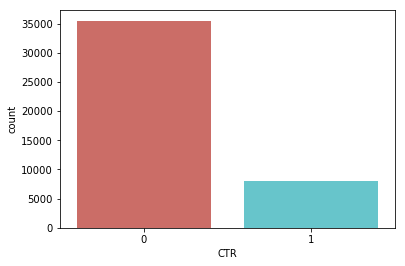

In [162]:
sns.countplot(x='CTR',data=data, palette='hls')
plt.show()

In [289]:
count_0=len(data[data['CTR']==0])
count_1=len(data[data['CTR']==1])
print('% of CTR<1%:', count_0/(count_0+count_1))
print('% of CTR>=1%:', count_1/(count_0+count_1))

% of CTR<1%: 0.8162096254716114
% of CTR>=1%: 0.1837903745283887


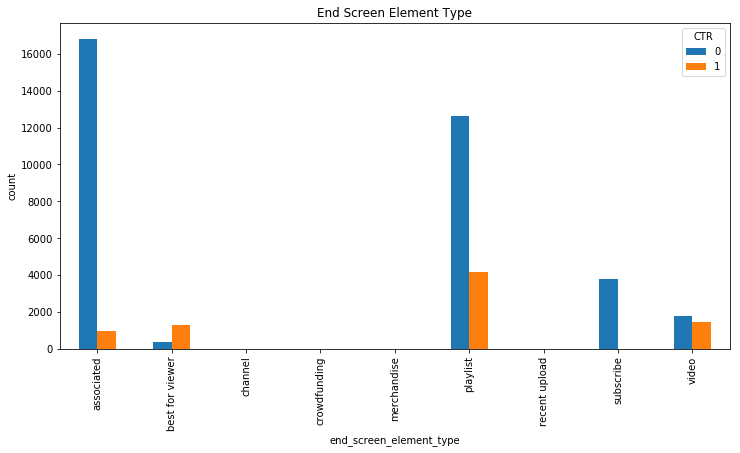

In [164]:
data.groupby(['end_screen_element_type', 'CTR']).size().unstack().plot(kind='bar', title="End Screen Element Type", figsize=(12,6))
plt.ylabel('count')


In [165]:
data.groupby(['end_screen_element_type', 'CTR']).size()

end_screen_element_type  CTR
associated               0      16821
                         1        979
best for viewer          0        396
                         1       1312
channel                  0          8
                         1          5
crowdfunding             0          1
                         1          1
merchandise              0         31
playlist                 0      12600
                         1       4201
recent upload            0          4
                         1          1
subscribe                0       3810
                         1         32
video                    0       1808
                         1       1458
dtype: int64

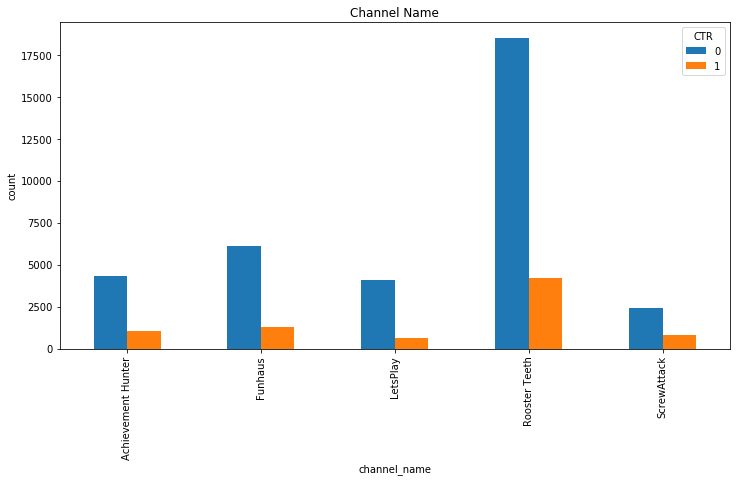

In [166]:
data.groupby(['channel_name', 'CTR']).size().unstack().plot(kind='bar', title="Channel Name", figsize=(12,6))
plt.ylabel('count')

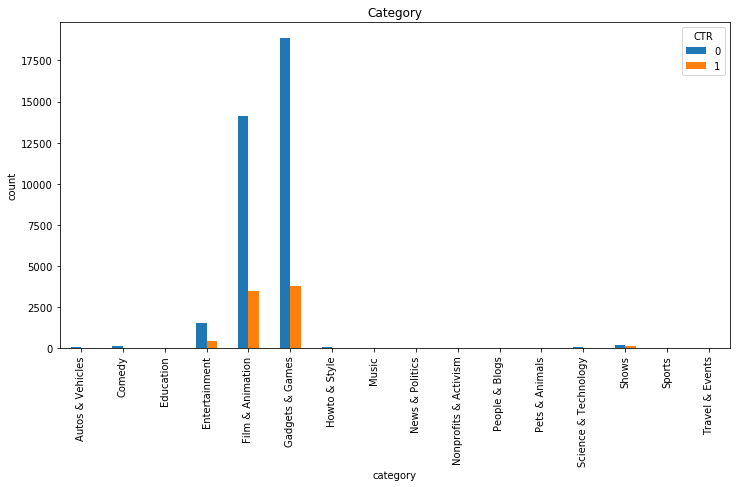

In [167]:
data.groupby(['category', 'CTR']).size().unstack().plot(kind='bar', title="Category", figsize=(12,6))
plt.ylabel('count')

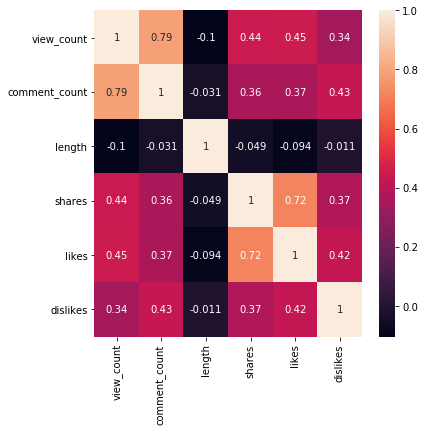

In [168]:
# Correlation between numerical features (view_count & comment_count are highly correlated)
plt.figure(figsize=(6,6))
sns.heatmap(data[['view_count','comment_count','length','shares','likes','dislikes']].corr(), annot=True)
plt.show()

## Prep Work For Modeling
### Categorical Features -- One Hot Encoding
### Numerical Features -- Standardizing

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

In [187]:
from sklearn.model_selection import train_test_split

In [194]:

features = range(1,12)
X= data.iloc[:,features]
y= data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [195]:
X_train.shape

(34774, 11)

In [196]:
X_test.shape


(8694, 11)

In [208]:
X_train.head()

,view_count,comment_count,length,shares,likes,dislikes,avg_view_percent,impressions,end_screen_element_type,channel_name,category
30512,192025,371,538,90,115,7,5.000000,635,associated,Rooster Teeth,Film & Animation
29146,940950,3395,221,643,4650,40,6.083333,81,associated,Rooster Teeth,Film & Animation
12800,347784,643,3026,70,704,29,1.878613,676,playlist,Achievement Hunter,Gadgets & Games
8591,470191,706,1108,113,1513,10,0.902307,37066,video,Funhaus,Gadgets & Games
31107,205157,176,159,3,154,4,2.554502,4,best for viewer,Rooster Teeth,Film & Animation


#### One Hot Encoding

In [209]:
# Train set One Hot Encoding
A = X_train.select_dtypes(include=[object])
A.head(3)

,end_screen_element_type,channel_name,category
30512,associated,Rooster Teeth,Film & Animation
29146,associated,Rooster Teeth,Film & Animation
12800,playlist,Achievement Hunter,Gadgets & Games


In [210]:
# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()


# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
A_2 = A.apply(le.fit_transform)
A_2.head()

,end_screen_element_type,channel_name,category
30512,0,3,4
29146,0,3,4
12800,4,0,5
8591,7,1,5
31107,1,3,4


In [219]:
A_2.shape

(34774, 3)

In [216]:
# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()

# 2. FIT
enc.fit(A_2)

# 3. Transform
one_hot_A = enc.transform(A_2).toarray()


In [218]:
one_hot_A.shape

(34774, 29)

In [220]:
one_hot_A=pd.DataFrame(one_hot_A)

In [223]:
one_hot_A.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
X_train_hot=X_train.iloc[:,range(0,8)]
X_train_hot.head()

,view_count,comment_count,length,shares,likes,dislikes,avg_view_percent,impressions
30512,192025,371,538,90,115,7,5.000000,635
29146,940950,3395,221,643,4650,40,6.083333,81
12800,347784,643,3026,70,704,29,1.878613,676
8591,470191,706,1108,113,1513,10,0.902307,37066
31107,205157,176,159,3,154,4,2.554502,4


In [227]:
X_train_hot=pd.concat([X_train_hot.reset_index(drop=True), one_hot_A], axis=1)
#df_c = pd.concat([df_a.reset_index(drop=True), df_b], axis=1)

In [229]:
X_train_hot.head()

,view_count,comment_count,length,shares,likes,dislikes,avg_view_percent,impressions,0,1,...,19,20,21,22,23,24,25,26,27,28
0,192025,371,538,90,115,7,5.000000,635,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,940950,3395,221,643,4650,40,6.083333,81,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,347784,643,3026,70,704,29,1.878613,676,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,470191,706,1108,113,1513,10,0.902307,37066,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,205157,176,159,3,154,4,2.554502,4,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
# Test set One Hot Encoding
B = X_test.select_dtypes(include=[object])
B_2 = B.apply(le.fit_transform)
B_2.head()

,end_screen_element_type,channel_name,category
30179,5,3,4
10224,0,1,5
24907,5,2,5
39554,5,3,4
14358,5,0,5


In [231]:
B_2.shape

(8694, 3)

In [232]:
enc.fit(B_2)
one_hot_B = enc.transform(B_2).toarray()
one_hot_B.shape

(8694, 29)

In [233]:
one_hot_B=pd.DataFrame(one_hot_B)
X_test_hot=X_test.iloc[:,range(0,8)]
X_test_hot=pd.concat([X_test_hot.reset_index(drop=True), one_hot_B], axis=1)

In [234]:
X_test_hot.head()

,view_count,comment_count,length,shares,likes,dislikes,avg_view_percent,impressions,0,1,...,19,20,21,22,23,24,25,26,27,28
0,350993,522,6085,100,185,10,0.284091,704,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,434801,1552,725,25,302,5,17.099099,246,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1838783,8204,2305,34,90,5,6.937086,185,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,591020,739,117,2,6,2,4.413223,251,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,999873,963,572,353,3207,51,1.253149,5471,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [235]:
X_test_hot.shape

(8694, 37)

#### Standardizing Numerical Features

In [236]:
from sklearn.preprocessing import StandardScaler

In [237]:
X_train_hot.iloc[:,range(0,8)]=StandardScaler().fit_transform(X_train_hot.iloc[:,range(0,8)])

In [238]:
X_train_hot.head()

,view_count,comment_count,length,shares,likes,dislikes,avg_view_percent,impressions,0,1,...,19,20,21,22,23,24,25,26,27,28
0,-0.548247,-0.280545,-0.455900,-0.137958,-0.405325,-0.119772,-0.501638,-0.237529,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.117305,0.273591,-0.650515,0.681139,1.296795,0.032069,-0.420815,-0.261692,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.409828,-0.230702,1.071556,-0.167582,-0.184256,-0.018545,-0.734512,-0.235741,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.301047,-0.219158,-0.105960,-0.103891,0.119386,-0.105969,-0.807350,1.351399,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.536577,-0.316278,-0.688579,-0.266821,-0.390687,-0.133576,-0.684086,-0.265050,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [240]:
X_train_hot['view_count'].var()

1.0000287579443821

In [241]:
X_train_hot['view_count'].mean()

-1.3690217776478608e-17

In [242]:
X_test_hot.iloc[:,range(0,8)]=StandardScaler().fit_transform(X_test_hot.iloc[:,range(0,8)])
X_test_hot.head()

,view_count,comment_count,length,shares,likes,dislikes,avg_view_percent,impressions,0,1,...,19,20,21,22,23,24,25,26,27,28
0,-0.409542,-0.241659,2.867431,-0.115519,-0.384642,-0.118580,-0.854265,-0.234008,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.333281,-0.058579,-0.341529,-0.220050,-0.339090,-0.144516,0.413920,-0.253677,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.944279,1.123799,0.604396,-0.207506,-0.421628,-0.144516,-0.352497,-0.256297,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.191129,-0.203088,-0.705530,-0.252106,-0.454331,-0.160077,-0.542846,-0.253462,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.180909,-0.163273,-0.433128,0.237096,0.791905,0.094090,-0.781178,-0.029291,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling
### Logistic Regression
#### Model1: default setting 

In [244]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
l = LogisticRegression()
l.fit(X_train_hot,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [253]:

y_pred=l.predict_proba(X_test_hot)[:,1]
print('Log Loss',log_loss(y_test,y_pred))

Log Loss 0.372149562091


In [254]:
from scipy import stats
stats.describe(y_pred)

DescribeResult(nobs=8694, minmax=(0.001089480008625902, 0.99507066538069044), mean=0.16466670900206393, variance=0.032542851960263117, skewness=2.0003871848485146, kurtosis=4.106877535144458)

In [255]:
y_pred  # predicted probability for CTR>=1%

array([ 0.06479188,  0.05659286,  0.11407422, ...,  0.23834553,
        0.22654686,  0.04938181])

In [264]:
y_pred2 = l.predict(X_test_hot) # this returns the predicted labels (threshold P>0.5)

In [263]:
print('Accuracy of logistic regression classifier on test set:',l.score(X_test_hot,y_test))
#Returns the mean accuracy on the given test data and labels

Accuracy of logistic regression classifier on test set: 0.8452956061651714


##### Confusion Matrix

In [265]:

from sklearn.metrics import confusion_matrix
confusion_matrix_logit = confusion_matrix(y_test, y_pred2)
print(confusion_matrix_logit)

[[6928  135]
 [1210  421]]


In [276]:
(6928+421)/(135+1210+6928+421)

0.8452956061651714

In [266]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred2))

             precision    recall  f1-score   support

          0       0.85      0.98      0.91      7063
          1       0.76      0.26      0.39      1631

avg / total       0.83      0.85      0.81      8694



In [284]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred2)

0.25812385039852853

In [286]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred2)

0.38500228623685417

In [280]:
# How is F-1 score caluclated?
(2*0.76*0.26)/(0.76+0.26) # 0.39
(0.91*7063+0.39*1631)/(8694)

0.8124476650563607

In [270]:
from sklearn.metrics import roc_auc_score
logit_roc_auc = roc_auc_score(y_test, l.predict(X_test_hot))

In [275]:
print('AUC:', logit_roc_auc)

AUC: 0.619505079666


In [272]:
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, l.predict(X_test_hot))
fpr, tpr, thresholds = roc_curve(y_test, l.predict_proba(X_test_hot)[:,1])
fpr, tpr, thresholds

(array([  0.00000000e+00,   0.00000000e+00,   1.41582897e-04, ...,
          9.84709047e-01,   9.84709047e-01,   1.00000000e+00]),
 array([  6.13120785e-04,   1.22624157e-03,   1.22624157e-03, ...,
          9.99386879e-01,   1.00000000e+00,   1.00000000e+00]),
 array([ 0.99507067,  0.99196068,  0.98195234, ...,  0.0031181 ,
         0.00308139,  0.00108948]))

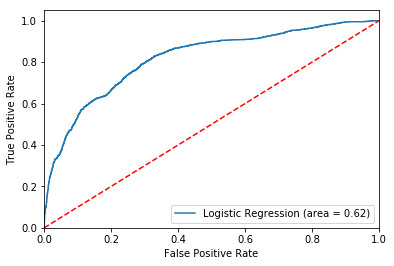

In [274]:
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

What else can be done for Logsitic Model:
<br>
Combine some levels in the categorical features
<br>
Use Oversampling or other methods to achieve balanced data, or try set class_weight='balanced'
<br>
Look into P-Values and select only important features

#### Model2: balanced weight 

In [290]:
l2 = LogisticRegression(class_weight='balanced')
l2.fit(X_train_hot,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [291]:
y_pred=l2.predict_proba(X_test_hot)[:,1]
print('Log Loss',log_loss(y_test,y_pred))

Log Loss 0.472810272365


In [292]:
y_pred2 = l2.predict(X_test_hot)

In [293]:
print('Accuracy of logistic regression classifier on test set:',l2.score(X_test_hot,y_test))

Accuracy of logistic regression classifier on test set: 0.793305728088


In [294]:
confusion_matrix_logit = confusion_matrix(y_test, y_pred2)
print(confusion_matrix_logit)

[[5795 1268]
 [ 529 1102]]


In [295]:
print(classification_report(y_test, y_pred2))

             precision    recall  f1-score   support

          0       0.92      0.82      0.87      7063
          1       0.46      0.68      0.55      1631

avg / total       0.83      0.79      0.81      8694



In [296]:
logit_roc_auc = roc_auc_score(y_test, l2.predict(X_test_hot))
print('AUC:', logit_roc_auc)

AUC: 0.748065995859
